In [1]:
# loading modules
import ee
import geemap
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# initialize ee 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# import all FMSE py functions 
from FMSE import *


## Area of Interest

### a) Through filtering ADM2 boundaries

In [2]:
# CASE 1: Pakistan Floods 2022

city = 'Shikarpur'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2022-03-01')
endDate = ee.Date('2022-08-01')
predays = 60
postdays = 30

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False



In [3]:
# Case 2: Jakarta, Indonesia Floods 2020

city = 'Jakarta'
city_shp = ee.FeatureCollection("projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM1")\
    .filter(ee.Filter.eq('shapeName', 'Jakarta Special Capital Region'))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2019-05-01')
endDate = ee.Date('2019-12-30')
predays = 40
postdays = 10

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False



In [2]:
# 1 Iberville Parish
# 2 East Baton Rouge Parish

# Case 3: USA Floods 2016

city = 'Iberville Parish'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2016-01-01')
endDate = ee.Date('2016-08-09')
predays = 60
postdays = 20

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False



In [3]:

# Case 4: Ernakulam, Kerala, India Floods 2018

city = 'Ernakulam'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2018-03-01')
endDate = ee.Date('2018-08-07')
predays = 60
postdays = 20

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False



In [4]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(aoi, {}, 'AOI')
Map.addLayer(city_shp, {}, 'City')
Map

Map(center=[10.04522180037863, 76.5001771098705], controls=(WidgetControl(options=['position', 'transparent_bg…

### b) Through Drawing shape on map 

In [2]:
# load the map and then draw any shape on it
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# get drawm layer from map
aoi = Map.draw_last_feature
aoi.getInfo()

### c) Through providing shape of geometry as EE object

In [ ]:
# test areas
aoi = ee.Geometry.Polygon([[[67.571411, 26.280487],
    [67.571411, 26.587913],
    [68.083649, 26.587913],
    [68.083649, 26.280487],
    [67.571411, 26.280487]]])

#aoi = ee.Geometry.Polygon(
#    [[[67.98392410136336, 26.049909335428502],
#      [67.98392410136336, 25.42892423506662],
#      [68.59778518534773, 25.42892423506662],
#      [68.59778518534773, 26.049909335428502]]])

## Flood layer Masking

In [5]:
# Fetching pre and post-flood images
s1_pre = get_s1_col(startDate, predays, aoi).select(['VV', 'VH'])
s1_post = get_s1_col(endDate, postdays, aoi).select(['VV', 'VH'])

print('Images in S1 Pre: ', s1_pre.size().getInfo())
print('Images in S1 Post: ', s1_post.size().getInfo())

# Calculate Z-score
zscore = calculate_zscore(s1_pre, s1_post, aoi)

# Generate flood masks
flood_class, flood_layer = map_floods(zscore, aoi, zvv_value, zvh_value, water_value, elev_value, slope_value, under_estimate)

print('Done with flood masking...')

Images in S1 Pre:  5
Images in S1 Post:  6
Done with flood masking...


In [6]:
# Run flood mapping example
flood_binary = flood_mapping(aoi, s1_post, flood_layer, num_samples, split)
print('Done with flood mapping...')

Done with preparing datasets...
Done with creating sample feature collection...
Done with creating training and validation samples...
Done with classification...
Training Accuracy Metrics:
Overall Accuracy: 0.9851024208566108
Kappa: 0.9702047383898352
Producer's Accuracy: [[0.9827160493827161], [0.9875156054931336]]
User's Accuracy: [[0.9875930521091811, 0.9826086956521739]]
F1 Score: 0.9850560398505603
Validation Accuracy Metrics:
Overall Accuracy: 0.7429305912596401
Kappa: 0.48644152826551895
Producer's Accuracy: [[0.7736842105263158], [0.7135678391959799]]
User's Accuracy: [[0.7205882352941176, 0.7675675675675676]]
F1 Score: 0.7395833333333335
Done with accuracy metrics...
Done with flood mapping...


In [7]:
# Run susceptibility analysis example
flood_susceptibility_prob = susceptibility_analysis(aoi, endDate, flood_binary, num_samples, split)
sus_catagory = quantile_based_categorization(flood_susceptibility_prob, city_shp)


flood_susceptibility_prob = flood_susceptibility_prob.clip(city_shp)
flood_binary = flood_binary.clip(city_shp)
sus_catagory = sus_catagory.clip(city_shp)



print('Done with susceptibility analysis...')

Done with preparing datasets for susceptibility analysis...
Size of label collection: 2000
Bands for susceptibility analysis: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDWI', 'NDBI', 'elevation', 'slope', 'aspect']
Training sus first:  {'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'NDBI': -0.25153055787086487, 'NDVI': 0.6439537405967712, 'NDWI': -0.5939325094223022, 'SR_B1': 0.01767624999999999, 'SR_B2': 0.025073749999999992, 'SR_B3': 0.05367374999999999, 'SR_B4': 0.04562999999999999, 'SR_B5': 0.21068499999999998, 'SR_B6': 0.12599875000000002, 'SR_B7': 0.06668125, 'aspect': 266.3477478027344, 'elevation': 8.039999961853027, 'label': 1, 'random': 0.5223369163923026, 'slope': 0.9142171144485474}}
Validation F1 Score: 0.7294117647058823
Validation Producer Accuracy: [0.6828193832599119]
Validation Consumer Accuracy: None
Done with susceptibility analysis...


### Visualize Data on the Map

In [8]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(city_shp, {}, 'City Boundaries')
Map.addLayer(aoi, {}, 'AOI Boundary')
Map.addLayer(flood_class.clip(city_shp), {'min': 0, 'max': 4, 'palette': ['#FFFFFF','#FFA500','#FFFF00','#FF0000','#0000FF']}, 'Flood class')# non-flooded, vv, vh, vv+vh, water
Map.addLayer(flood_layer.clip(city_shp), {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood layer')
Map.addLayer(flood_binary, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood Binary')
Map.addLayer(flood_susceptibility_prob, {'min': 0.1, 'max': 0.9, 'palette': ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility')

Map.addLayer(sus_catagory, {'min': 1, 'max': 5, 'palette': ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility Categorical')
Map

Map(center=[10.04522180037863, 76.5001771098705], controls=(WidgetControl(options=['position', 'transparent_bg…

### Model Tuning Optional

In [27]:
import time


s1_post = s1_post
flood_layer = flood_layer
aoi = aoi



def update_feature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)
bands = ['VV', 'VH', 'elevation', 'slope', 'aspect', 'dtriver']

def prepare_datasets(aoi, projection='EPSG:4326', scale=30):
    """
    Prepare DEM, slope, and aspect datasets.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    projection (str): Projection to reproject the images. Default is 'EPSG:4326'.
    scale (int): Scale for reprojection. Default is 30.

    Returns:
    tuple: DEM, slope, aspect, and dtriver images reprojected to the specified projection.
    """
    dem_proj = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")\
        .filterBounds(aoi)\
        .mosaic()\
        .clip(aoi)\
        .setDefaultProjection('EPSG:3857', None, 30)

    slope_proj = ee.Terrain.slope(dem_proj)
    aspect_proj = ee.Terrain.aspect(dem_proj)

    dem = dem_proj.reproject(crs=projection, scale=scale)
    slope = slope_proj.reproject(crs=projection, scale=scale)
    aspect = aspect_proj.reproject(crs=projection, scale=scale)
    
    shoreline = ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/mainlands')\
        .merge(ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/big_islands'))\
        .filterBounds(aoi)
    
    rivers = ee.FeatureCollection("projects/sat-io/open-datasets/HydroAtlas/RiverAtlas_v10")\
        .filterBounds(aoi)

    # Combine rivers and shoreline into a single FeatureCollection
    rivers_and_shoreline = rivers.merge(shoreline)

    # Generate distance rasters for roads, and rivers+shoreline
    dtriver = distance_to_feature(rivers_and_shoreline, projection, scale, aoi)
    #rivers_and_shoreline_distance = distance_to_feature(rivers_and_shoreline, 30)

    return dem.rename('elevation'), slope, aspect, dtriver.rename('dtriver')


def prepare_samples(flood_layer, num_samples, aoi, scale=10, split=0.8):
    sample = flood_layer.stratifiedSample(
        numPoints=num_samples,
        classBand='label',
        region=aoi,
        scale=scale,
        seed=5,
        tileScale=1.5,
        geometries=True
    )
    label = sample.map(update_feature)

    image = s1_post.mean().clip(aoi).toFloat()
    
    dem, slope, aspect, dtriver = prepare_datasets(aoi, scale=30)
    
    image = image.addBands(dem).addBands(slope).addBands(aspect).addBands(dtriver)
    sample_all = image.sampleRegions(
        collection=label,
        properties=['label'],
        scale=scale
    ).randomColumn()

    training = sample_all.filter(ee.Filter.lt('random', split))
    validation = sample_all.filter(ee.Filter.gte('random', split))
    return image, training, validation

def evaluate_classifier(classifier, training, validation):
    start_time = time.time()
    
    trained_classifier = classifier.train(
        features=training,
        classProperty='label',
        inputProperties=bands
    )
    
    training_classified = training.classify(trained_classifier)
    validation_classified = validation.classify(trained_classifier)
    
    training_accuracy = training_classified.errorMatrix('label', 'classification')
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    end_time = time.time()
    prediction_time = end_time - start_time
    
    return {
        'train_f1': training_accuracy.fscore().getInfo()[1] if len(training_accuracy.fscore().getInfo()) > 1 else None,
        'validation_f1': validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None,
        'train_producer_accuracy': training_accuracy.producersAccuracy().getInfo()[1] if len(training_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'validation_producer_accuracy': validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'train_consumer_accuracy': training_accuracy.consumersAccuracy().getInfo()[1] if len(training_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'validation_consumer_accuracy': validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'prediction_time': prediction_time
    }

def compare_models(flood_layer, s1_post, aoi, num_samples=1000, split=0.8):
    
    image, training, validation = prepare_samples(flood_layer, num_samples, aoi, scale=10, split=split)
    bands = image.bandNames().getInfo()
    print(bands)
    classifiers = {
        'RandomForest': ee.Classifier.smileRandomForest(100),
        'GradientTreeBoost': ee.Classifier.smileGradientTreeBoost(50),
        'DecisionTree': ee.Classifier.smileCart(),
        'SVM': ee.Classifier.libsvm()
    }

    results = {}
    for name, classifier in classifiers.items():
        print(f"Evaluating {name} classifier...")
        results[name] = evaluate_classifier(classifier, training, validation)
    
    for name, metrics in results.items():
        print(f"\nClassifier: {name}")
        print(f"Training F1 Score: {metrics['train_f1']}")
        print(f"Validation F1 Score: {metrics['validation_f1']}")
        print(f"Training Producer Accuracy: {metrics['train_producer_accuracy']}")
        print(f"Validation Producer Accuracy: {metrics['validation_producer_accuracy']}")
        print(f"Training Consumer Accuracy: {metrics['train_consumer_accuracy']}")
        print(f"Validation Consumer Accuracy: {metrics['validation_consumer_accuracy']}")
        print(f"Prediction Time: {metrics['prediction_time']} seconds")

    return results

# Example usage
results = compare_models(flood_layer, s1_post, aoi, num_samples=1000, split=0.8)

# results to df

models_compare_df = pd.DataFrame(results).T
models_compare_df.reset_index(inplace=True)
models_compare_df.rename(columns={'index': 'Model'}, inplace=True)
models_compare_df.to_csv(f'{city}_all_models_compare_df.csv', index=False)
models_compare_df


['VV', 'VH', 'elevation', 'slope', 'aspect', 'dtriver']
Evaluating RandomForest classifier...
Evaluating GradientTreeBoost classifier...
Evaluating DecisionTree classifier...
Evaluating SVM classifier...

Classifier: RandomForest
Training F1 Score: 0.9941747572815535
Validation F1 Score: 0.7412280701754387
Training Producer Accuracy: [0.9896907216494846]
Validation Producer Accuracy: [0.7544642857142857]
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction Time: 0.0002751350402832031 seconds

Classifier: GradientTreeBoost
Training F1 Score: 0.9356499356499357
Validation F1 Score: 0.7321428571428571
Training Producer Accuracy: [0.9368556701030928]
Validation Producer Accuracy: [0.7321428571428571]
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction Time: 0.00026607513427734375 seconds

Classifier: DecisionTree
Training F1 Score: 1
Validation F1 Score: 0.6559633027522935
Training Producer Accuracy: [1]
Validation Producer Accuracy: [0.

,Model,train_f1,validation_f1,train_producer_accuracy,validation_producer_accuracy,train_consumer_accuracy,validation_consumer_accuracy,prediction_time
0,RandomForest,0.994175,0.741228,[0.9896907216494846],[0.7544642857142857],None,None,0.000275
1,GradientTreeBoost,0.93565,0.732143,[0.9368556701030928],[0.7321428571428571],None,None,0.000266
2,DecisionTree,1,0.655963,[1],[0.6383928571428571],None,None,0.000559
3,SVM,0.2678,0.282686,[0.16237113402061856],[0.17857142857142858],None,None,0.000343


Evaluated RandomForest with 10 trees: F1 Score = 0.6995305164319249
Evaluated RandomForest with 30 trees: F1 Score = 0.7366071428571429
Evaluated RandomForest with 50 trees: F1 Score = 0.7400881057268722
Evaluated RandomForest with 60 trees: F1 Score = 0.7384615384615384
Evaluated RandomForest with 70 trees: F1 Score = 0.7412280701754387
Evaluated RandomForest with 80 trees: F1 Score = 0.7412280701754387
Evaluated RandomForest with 90 trees: F1 Score = 0.7379912663755459
Evaluated RandomForest with 100 trees: F1 Score = 0.7412280701754387
Evaluated RandomForest with 110 trees: F1 Score = 0.7472527472527472
Evaluated RandomForest with 120 trees: F1 Score = 0.7456140350877194
Evaluated RandomForest with 130 trees: F1 Score = 0.7478260869565218
Evaluated RandomForest with 140 trees: F1 Score = 0.7510917030567688
Evaluated RandomForest with 150 trees: F1 Score = 0.7543859649122806
Evaluated RandomForest with 200 trees: F1 Score = 0.7439824945295405
Evaluated RandomForest with 300 trees: F1

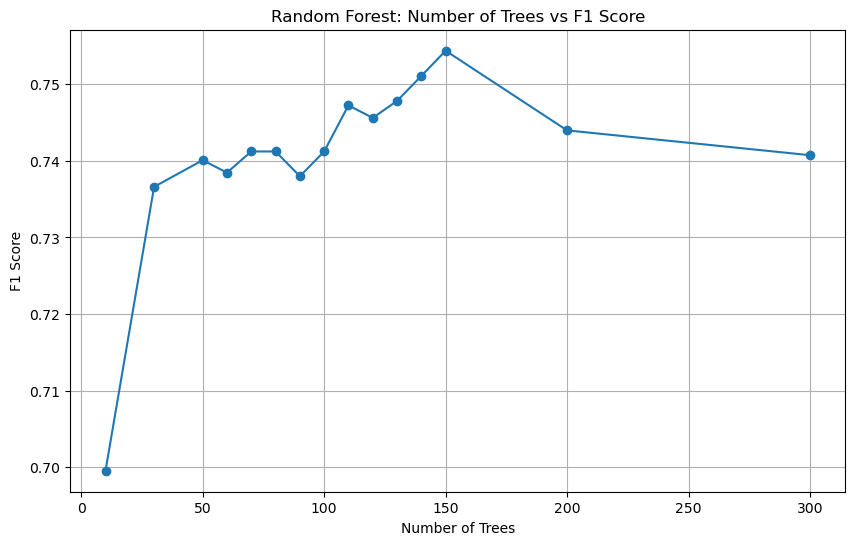

,Number of Trees,F1 Score
0,10,0.699531
1,30,0.736607
2,50,0.740088
3,60,0.738462
4,70,0.741228
5,80,0.741228
6,90,0.737991
7,100,0.741228
8,110,0.747253
9,120,0.745614


In [30]:
import matplotlib.pyplot as plt

def evaluate_rf_trees(training, validation, bands, num_trees_list):
    results = {}
    
    for num_trees in num_trees_list:
        classifier = ee.Classifier.smileRandomForest(num_trees).train(
            features=training,
            classProperty='label',
            inputProperties=bands
        )
        
        validation_classified = validation.classify(classifier)
        validation_accuracy = validation_classified.errorMatrix('label', 'classification')
        f1_score = validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None
        
        results[num_trees] = f1_score
        print(f"Evaluated RandomForest with {num_trees} trees: F1 Score = {f1_score}")
    
    return results

new_trees = [10, 30, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200, 300]
def fine_tune_rf_trees(flood_layer, s1_post, aoi, num_samples=200, split=0.8, num_trees_list=new_trees):
    if num_trees_list is None:
        num_trees_list = [10, 50, 100, 150, 200, 250, 300]

    
    image, training, validation = prepare_samples(flood_layer, num_samples, aoi, scale=10, split=split)
    bands = image.bandNames().getInfo()
    results = evaluate_rf_trees(training, validation, bands, num_trees_list)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel('Number of Trees')
    plt.ylabel('F1 Score')
    plt.title('Random Forest: Number of Trees vs F1 Score')
    plt.grid(True)
    plt.savefig(f'{city}_rf_trees_f1_score.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.show()
    
    return results

# Example usage
results_rf_trees = fine_tune_rf_trees(flood_layer, s1_post, aoi, num_samples=1000, split=0.8)
# save df results_rf_trees to csv
results_rf_trees_df = pd.DataFrame(results_rf_trees, index=[0]).T
results_rf_trees_df.reset_index(inplace=True)
results_rf_trees_df.rename(columns={'index': 'Number of Trees', 0: 'F1 Score'}, inplace=True)
results_rf_trees_df.to_csv(f'{city}_rf_trees_f1_score_df.csv', index=False)
results_rf_trees_df


# Exposure Analysis

## A) Exposure to Flood Hazard

### Population Exposed to Floods

In [11]:
total_exposed_population, total_population = calculate_flood_exposure(flood_binary, aoi)

# print total population without decimal points
print('Total population:', int(total_population.getInfo()))
print('Population exposed to flood hazard:', int(total_exposed_population.getInfo()))


Total population: 23953
Total population exposed to flood: 1512


### Population Exposed to flood hazard OR Susceptibility Levels

In [ ]:
# Calculate exposure dataframe

# unccomment below for exposure due to flood hazard calculation
#exposure_df = calculate_exposure_df(flood_binary, aoi, flood_map=True)

exposure_df = calculate_exposure_df(sus_catagory, aoi, flood_map=False, export=False)

print(exposure_df)


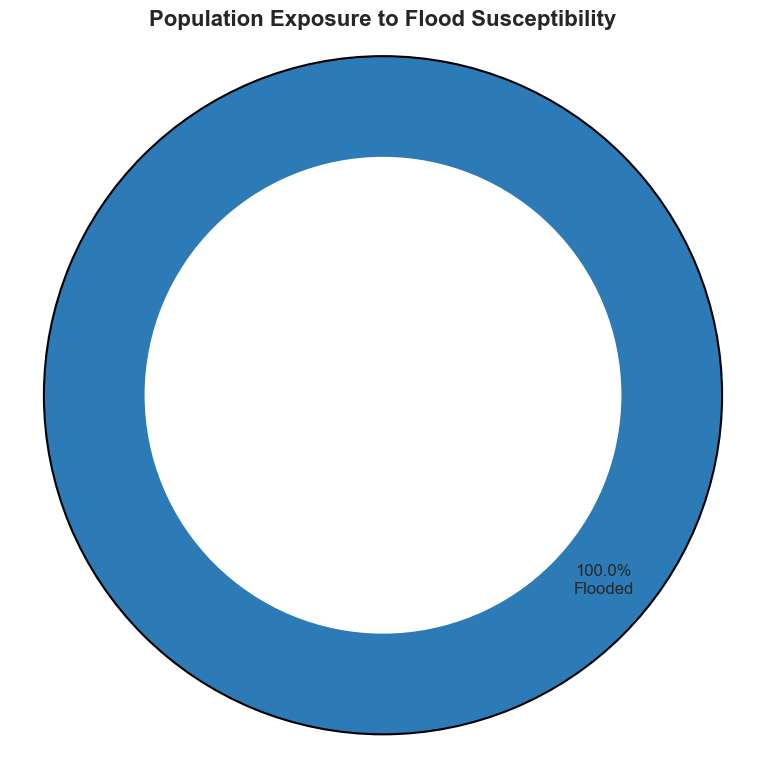

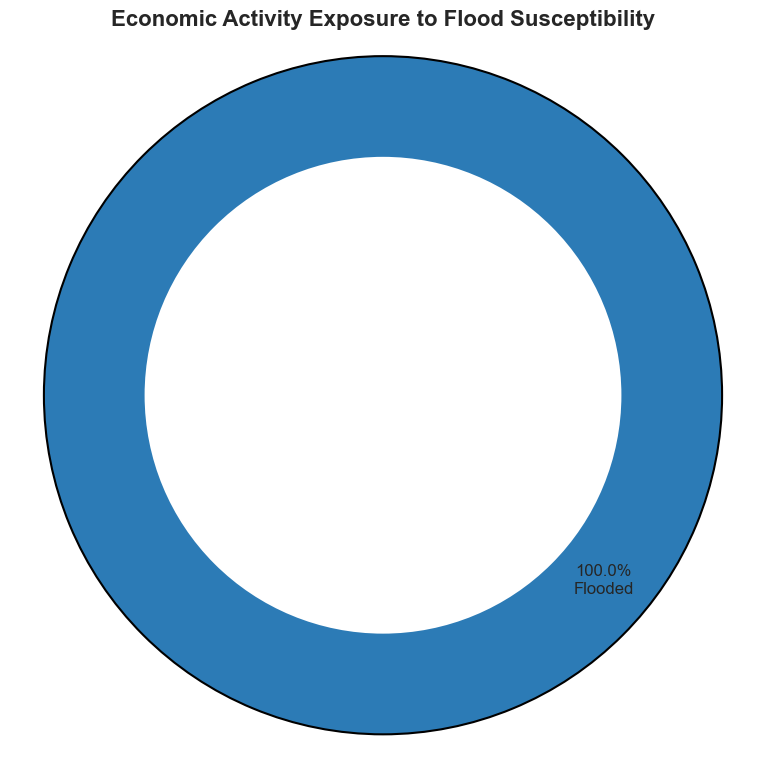

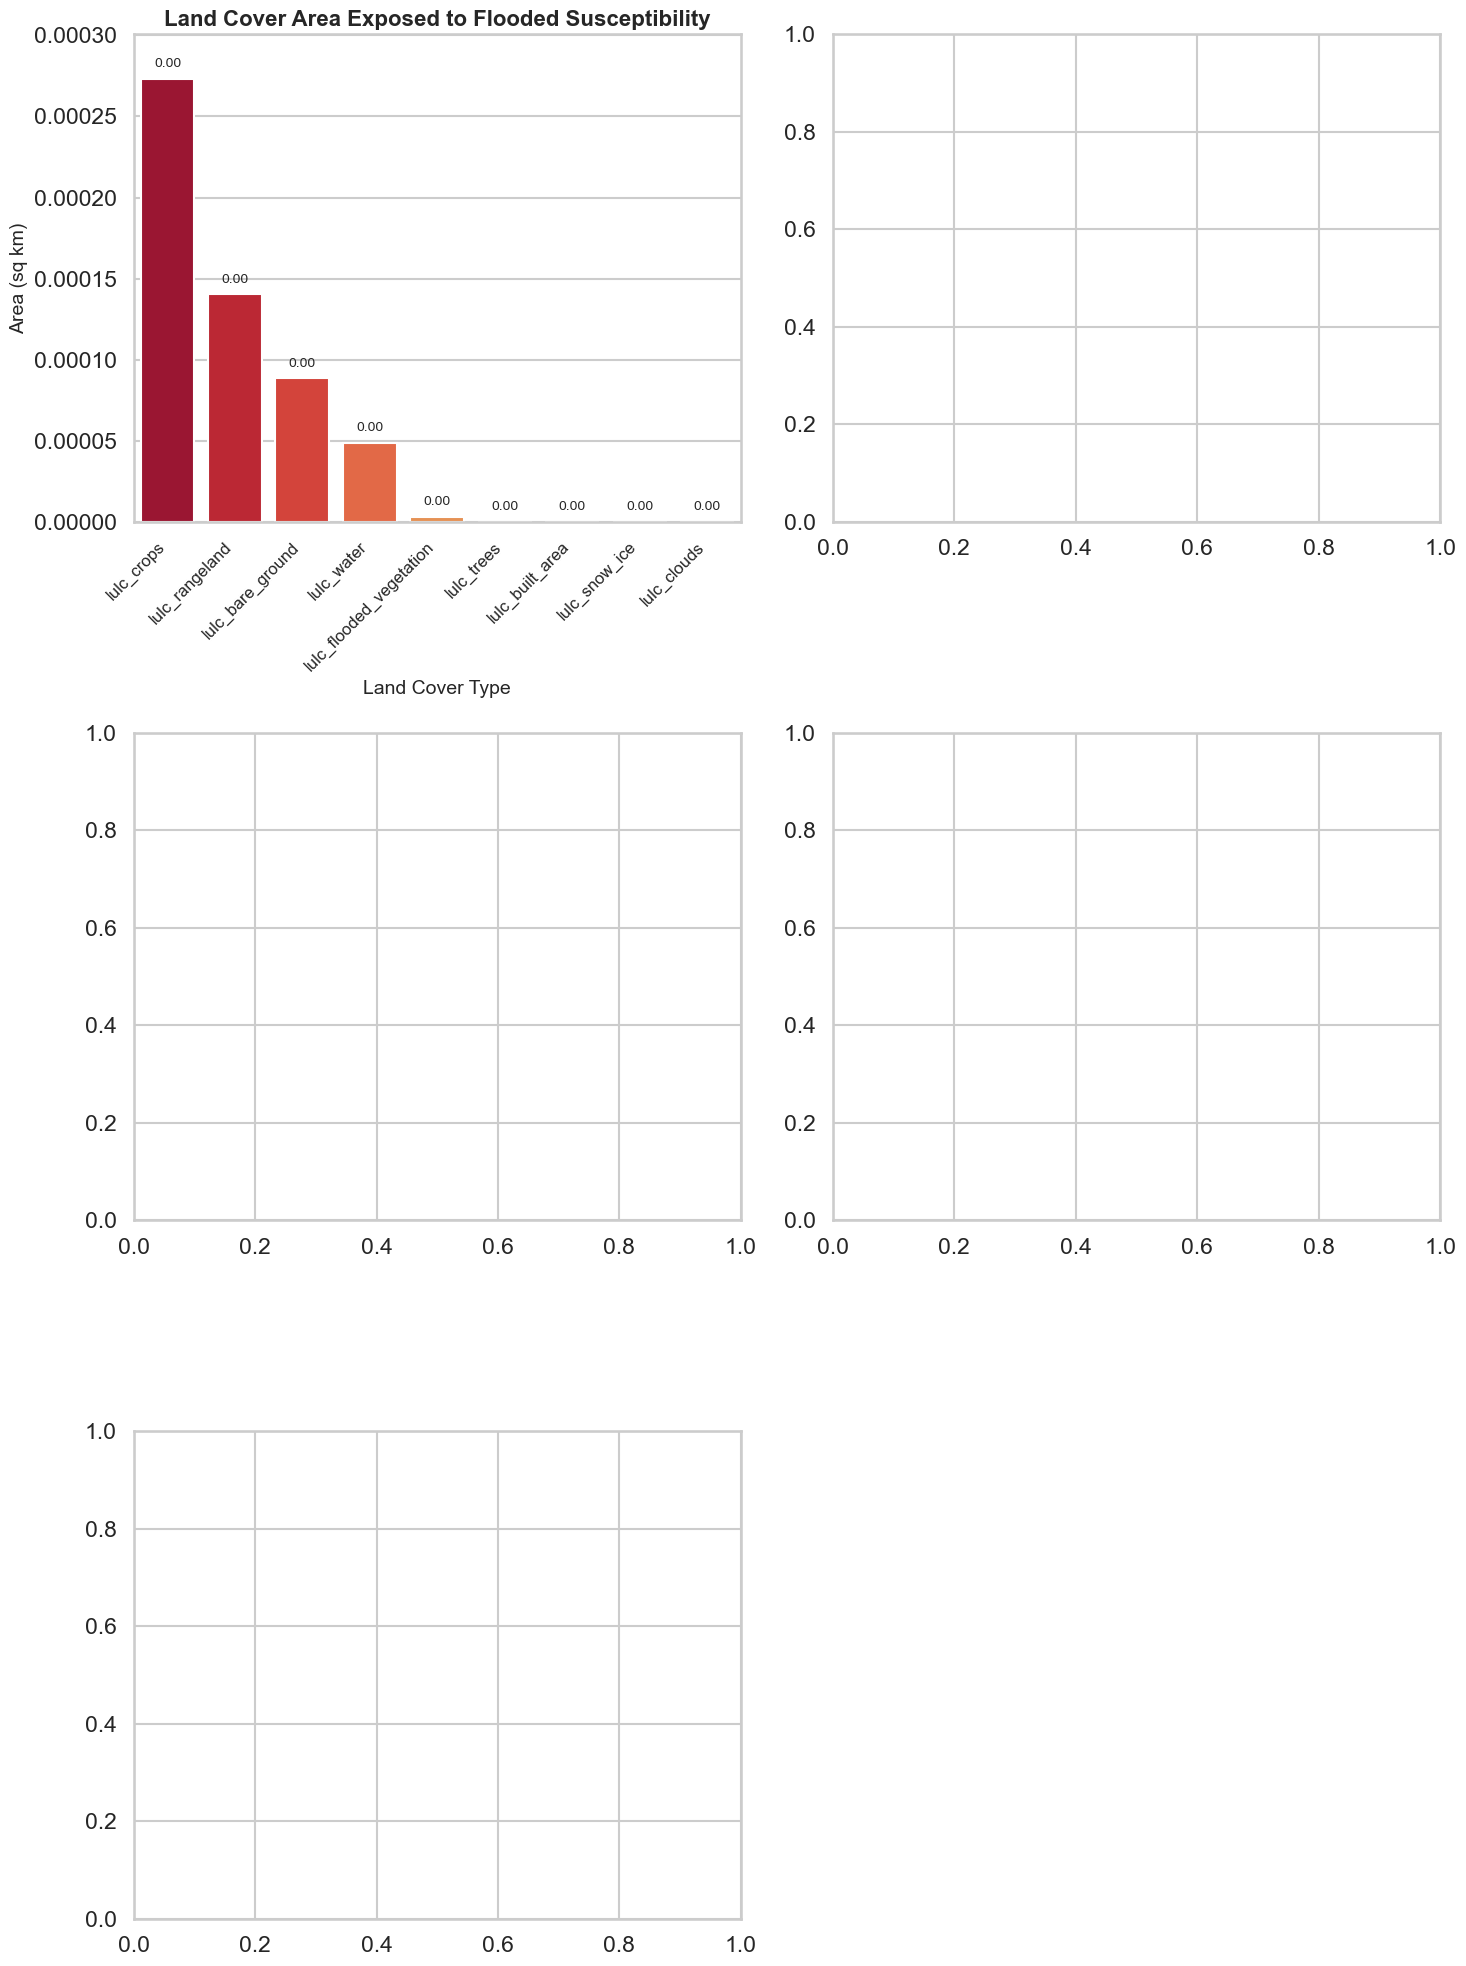

In [12]:
visualize_exposure(exposure_df, export=False)


## Optional Model tuning and comparison

In [ ]:
# test code to compare models

# Parameters
num_samples = 1000  # Number of sample points
split = 0.8  # Train-test split ratio
bands = ['VV', 'VH']  # Bands to use for classification

# Create the 'sample' feature collection
sample = flood_layer.stratifiedSample(
    numPoints=num_samples,
    classBand='label',
    region=aoi,
    scale=10,
    seed=5,
    tileScale=1.5,
    geometries=True
)

# Update label values: change non-flood (label 2) to 0
def updateFeature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)

label = sample.map(updateFeature)

# Verify label values
unique_labels = label.aggregate_array('label').distinct().getInfo()
print(f"Unique labels: {unique_labels}")

# Prepare image for classification
image = s1_post.mean().clip(aoi)

# Create training and validation samples
sample_all = image.select(bands).sampleRegions(
    collection=label,
    properties=['label'],
    scale=10
).randomColumn()

training = sample_all.filter(ee.Filter.lt('random', split))
validation = sample_all.filter(ee.Filter.gte('random', split))

# Define classifiers to compare
classifiers = {
    'RandomForest': ee.Classifier.smileRandomForest(115),
    'GradientTreeBoost': ee.Classifier.smileGradientTreeBoost(100),
    'DecisionTree': ee.Classifier.smileCart(),
    #'NaiveBayes': ee.Classifier.smileNaiveBayes(),
    'SVM': ee.Classifier.libsvm()
}

def evaluate_classifier(classifier, training, validation):
    start_time = time.time()
    
    trained_classifier = classifier.train(
        features=training,
        classProperty='label',
        inputProperties=bands
    )
    
    training_classified = training.classify(trained_classifier)
    validation_classified = validation.classify(trained_classifier)
    
    training_accuracy = training_classified.errorMatrix('label', 'classification')
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    end_time = time.time()
    prediction_time = end_time - start_time
    
    return {
        'train_f1': training_accuracy.fscore().getInfo()[1] if len(training_accuracy.fscore().getInfo()) > 1 else None,
        'validation_f1': validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None,
        'train_producer_accuracy': training_accuracy.producersAccuracy().getInfo()[1] if len(training_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'validation_producer_accuracy': validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'train_consumer_accuracy': training_accuracy.consumersAccuracy().getInfo()[1] if len(training_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'validation_consumer_accuracy': validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'prediction_time': prediction_time
    }

# Evaluate all classifiers
results = {}
for name, classifier in classifiers.items():
    print(f"Evaluating {name} classifier...")
    results[name] = evaluate_classifier(classifier, training, validation)

# Print results
for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"Training F1 Score: {metrics['train_f1']}")
    print(f"Validation F1 Score: {metrics['validation_f1']}")
    print(f"Training Producer Accuracy: {metrics['train_producer_accuracy']}")
    print(f"Validation Producer Accuracy: {metrics['validation_producer_accuracy']}")
    print(f"Training Consumer Accuracy: {metrics['train_consumer_accuracy']}")
    print(f"Validation Consumer Accuracy: {metrics['validation_consumer_accuracy']}")
    print(f"Prediction Time: {metrics['prediction_time']} seconds")

# Optionally, export the best classifier's results
# best_classifier_name = max(results, key=lambda k: results[k]['validation_f1'])
# best_classifier = classifiers[best_classifier_name].train(
#     features=training,
#     classProperty='label',
#     inputProperties=bands
# )
# classified_image = image.select(bands).classify(best_classifier)
# geemap.ee_export_image_to_drive(classified_image, description=f'best_classifier_{best_classifier_name}', folder='earth_engine', scale=10, region=aoi)


## Export Layers

In [17]:
import time

def export_layers(aoi, flood_binary, flood_class, flood_mapped, susceptibility_layer, susceptibility_category_layer,
                  export_flood_binary=True, export_flood_class=True, export_flood_mapped=True,
                  export_susceptibility_layer=True, export_susceptibility_category_layer=True):
    """
    Export specified layers to Google Drive.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    flood_binary (ee.Image): Flood binary layer.
    flood_class (ee.Image): Flood class layer.
    flood_mapped (ee.Image): Flood mapped layer.
    susceptibility_layer (ee.Image): Susceptibility layer.
    susceptibility_category_layer (ee.Image): Susceptibility category layer.
    export_flood_binary (bool): Flag to export flood binary layer.
    export_flood_class (bool): Flag to export flood class layer.
    export_flood_mapped (bool): Flag to export flood mapped layer.
    export_susceptibility_layer (bool): Flag to export susceptibility layer.
    export_susceptibility_category_layer (bool): Flag to export susceptibility category layer.
    """

    tasks = []
    aoi = aoi.geometry()
    if export_flood_binary:
        flood_binary_task = ee.batch.Export.image.toDrive(
            image=flood_binary,
            description=f'{city}_flood_mask_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_binary_task.start()
        tasks.append(flood_binary_task)

    if export_flood_class:
        flood_class_task = ee.batch.Export.image.toDrive(
            image=flood_class,
            description=f'{city}_flood_class_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_class_task.start()
        tasks.append(flood_class_task)

    if export_flood_mapped:
        flood_mapped_task = ee.batch.Export.image.toDrive(
            image=flood_mapped,
            description=f'{city}_flood_mapped_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_mapped_task.start()
        tasks.append(flood_mapped_task)

    if export_susceptibility_layer:
        susceptibility_task = ee.batch.Export.image.toDrive(
            image=susceptibility_layer,
            description=f'{city}_flood_susceptibility_layer',
            folder='FMSE',
            scale=30,
            region=aoi,
            maxPixels=1e13
        )
        susceptibility_task.start()
        tasks.append(susceptibility_task)

    if export_susceptibility_category_layer:
        susceptibility_category_task = ee.batch.Export.image.toDrive(
            image=susceptibility_category_layer,
            description=f'{city}_flood_susceptibility_category_layer',
            folder='FMSE',
            scale=30,
            region=aoi,
            maxPixels=1e13
        )
        susceptibility_category_task.start()
        tasks.append(susceptibility_category_task)

    def monitor_tasks(tasks):
        while any([task.status()['state'] in ['READY', 'RUNNING'] for task in tasks]):
            for task in tasks:
                status = task.status()
                description = status['description']
                state = status['state']
                print(f'Task {description} is {state}')
            time.sleep(30)  # Check every 30 seconds

    # Monitor the export tasks
    monitor_tasks(tasks)

export_layers(aoi, 
              flood_binary, flood_class, flood_binary, flood_susceptibility_prob, sus_catagory,
               export_flood_binary=True, 
               export_flood_class=True, 
               export_flood_mapped=True,
               export_susceptibility_layer=True, 
               export_susceptibility_category_layer=True)


Task Shikarpur_flood_mask_layer is READY
Task Shikarpur_flood_class_layer is READY
Task Shikarpur_flood_mapped_layer is READY
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is RUNNING
Task Shikarpur_flood_class_layer is RUNNING
Task Shikarpur_flood_mapped_layer is RUNNING
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is RUNNING
Task Shikarpur_flood_class_layer is RUNNING
Task Shikarpur_flood_mapped_layer is RUNNING
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is RUNNING
Task Shikarpur_flood_class_layer is RUNNING
Task Shikarpur_flood_mapped_layer is RUNNING
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is

In [47]:
# scale image between 1 to 100 (integers) and export
results_prob_scaled = results_prob.multiply(100).toInt()
geemap.ee_export_image(results_prob_scaled, filename='flood_susceptibility.tif', scale=30, region=aoi, file_per_band=False)

Generating URL ...
Please wait ...
An error occurred while downloading.
